In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Model Assumptions and Explaination

1. Sex determination for larval happens at metamorphism, since research cannot distinguish sex reversal and labile sex determination.
2. Growth rate is the same for all larval ages.
3. The ecosystem only involves larval, male and female juvenile, fish, and parasite.
4. Larval is filter feeder and their food source depends on E, the environment variable between 0 and 1, the reproducibility of the environment, such as algae availability.
5. E is the reproducibility of the environment, such as algae availability. E is between 0 and 1. 0 for lentic environment with the lowest food availability. 1 for stream environment with highest availability.
6. E is not affected by anything in the ecosystem, and is picked by hand.
7. All species have a capacity picked by hand. Such as L_max for larval, P_max for parasites. Saturation approaches 1 as population approaches capacity, 0 as population approaches 0.
6. Larval death rate increases as larval saturation increase and E decreases.
7. Male and Female death rate increases as saturation increases and as fish saturation decreases.
8. Ratio for larval to be come male is 0.78 when E is 0, 0.56 when E is 1, during metamorphism.
9. Male and Female both die shortly after reproduction. Male also dies because they also travel upstream to make nest.
10. The birth rate for larval is also limited by larval saturation. Meaning less eggs hatch when larval approaches max capacity.
11. Fish growth slows as fish saturates. Fish die more as parasites saturates.
12. Parasites growth increases as fish saturates and as larval saturates (assuming juvenile indirectly saturates due to this. No saturation is measured for juvenile to reduce complexity). Death for parasite is vice versa.


In [12]:
class Model:
    def __init__(
            self,
            seed=42,
            num_years=100,
            Larva_init=5000,
            Female_init=1000,
            Male_init=1000,
            Fish_init=30000,
            # environment
            E_init=0.5,
            # sex ratio change
            constant_male_ratio=None, # None or number between 0.56 and 0.78
            # metamorphism rate
            constant_metamorphism_rate=None # None or number between 1/3 and 1/10
            ):
        np.random.seed(seed)

        ######### Coefficients
        # larva
        self._L_max = 60000 # capacity for larva, we can tune all the max
        self._death_rate_L = 0.8 # max death rate of larva

        # juvenile (M and F)
        self._death_rate_J = 0.3 # natural death rate for juvenile
        self._reproduce_rate = 0.5 # when they reproduce they also die shortly after
        self._birth_rate = 60000 * 0.0005 * self._reproduce_rate # birth rate by adult female 30000 eggs per birth, 10% survive, 0.8 birth per year then die
        self._J_max = 10000

        # fish
        self._growth_rate_H = 0.3 # natural growth rate for fish
        self._death_rate_H = 0.1 # natural death rate of fish
        self._H_max = 60000 # capacity for fish

        # parasite
        self._kill_rate = 0.1 # kill rate for fish by a unit of parasite
        self._P_max = 1000 # capacity for parasite
        self._growth_rate_P = 1 # parasite growth rate
        self._death_rate_P = 1 # natural death rate for parasite

        # param
        self.constant_male_ratio = constant_male_ratio
        if self.constant_male_ratio is not None:
            self.constant_male_ratio = max(min(self.constant_male_ratio, 0.78), 0.56) # between 0.56 and 0.78

        self.constant_metamorphism_rate = constant_metamorphism_rate
        if self.constant_metamorphism_rate is not None:
            self.constant_metamorphism_rate = max(min(self.constant_metamorphism_rate, 1/3), 1/10) # between 1/10 and 1/3

        ######### Variables
        self.num_years = num_years
        self.years = np.arange(num_years, step=1)

        # larva
        self.L = np.zeros(num_years)
        self.L[0] = Larva_init

        # juvenile female
        self.F = np.zeros(num_years)
        self.F[0] = Female_init

        # juvenile male
        self.M = np.zeros(num_years)
        self.M[0] = Male_init

        # environment
        self.E = np.zeros(num_years)
        self.E[0] = E_init

        # fish
        self.H = np.zeros(num_years)
        self.H[0] = Fish_init

        # parasite = female + male
        self.P = np.zeros(num_years)
        self.P[0] = Female_init + Male_init

        self.populate_model()

        # print("modeling done")

    def populate_model(self):
        self.df = pd.DataFrame()

        for n in range(1, len(self.years)):
            self.L[n], self.M[n], self.F[n], self.H[n], self.P[n], self.E[n] = self.update(n, self.L[n-1], self.M[n-1], self.F[n-1], self.H[n-1], self.P[n-1], self.E[n-1])

    def update(self, year, L_old, M_old, F_old, H_old, P_old, E_old):
        metamorphism_rate = 1/3 - 7/30 * (1 - E_old) if self.constant_metamorphism_rate is None else self.constant_metamorphism_rate
        male_rate = 0.78 - 0.22 * E_old if self.constant_male_ratio is None else self.constant_male_ratio
        female_rate = 1 - male_rate

        # saturation
        fish_saturation = self.saturation(H_old, self._H_max) # between 0 and 1, measures how saturated fish is
        larval_saturation = self.saturation(L_old, self._L_max)

        # L_new
        # death rate increases as saturation increase and E decreases
        larval_death_rate = 0.5 * self._death_rate_L * larval_saturation + 0.5 * self._death_rate_L * (1 - E_old)
        L_survived_from_last_census = L_old * (1 - metamorphism_rate) * (1 - larval_death_rate) # did not age up and survived
        L_born = F_old * self._birth_rate * (1 - larval_saturation) # new born, assume also hatching limited by saturation (somehow related to environment)
        L_new = L_survived_from_last_census + L_born

        # F_new
        # death rate related to saturation of fish
        # survived and did not reproduce (female die shortly after reproduction, male also travels upstream and die)
        juvenile_death_rate = (1 - self._death_rate_J * (1 - fish_saturation)) * (1 - self._reproduce_rate)
        F_survived_from_last_census = F_old * juvenile_death_rate
        F_metamorphed = L_survived_from_last_census * metamorphism_rate * female_rate
        F_new = F_survived_from_last_census + F_metamorphed

        # M_new
        M_survived_from_last_census = M_old * juvenile_death_rate
        M_metamorphed = L_survived_from_last_census * metamorphism_rate * male_rate
        M_new = M_survived_from_last_census + M_metamorphed

        # H_new
        H_born = H_old * self._growth_rate_H * (1 - fish_saturation)
        # survived both natural death and parasite
        H_survived_from_last_census = H_old * (1 - self._death_rate_H) * (1 - self._kill_rate * larval_saturation)
        H_new = H_survived_from_last_census + H_born

        # P_new
        # death rate increases as parasite saturation increases, as fish saturation decreases, and as lamprey saturation decreases
        P_new = F_new + M_new

        # E_new
        E_new = E_old * (1 + 0.1 * (0.5 - larval_saturation)) # grow when saturation(larval) < 0.5, decay when saturation(larval) > 0.5
        E_new = min(max(E_new, 0), 1)

        # TODO: calculate anything else useful
        juvenile_natural_deaths = P_old * juvenile_death_rate
        larval_natural_deaths = L_old * larval_death_rate

        new_row = pd.DataFrame([{
            'year': year,
            'E': E_new,
            'L': L_new,
            'F': F_new,
            'M': M_new,
            'H': H_new,
            'P': P_new,
            'metamorphism_rate': metamorphism_rate,
            'male_rate': male_rate,
            'female_rate': female_rate,
            'fish_saturation': fish_saturation,
            'larval_saturation': larval_saturation,
            'larval_deaths': larval_natural_deaths,
            'larval_death_rate': larval_death_rate,
            'larval_survival_rate': 1 - larval_death_rate,
            'juvenile_natural_deaths': juvenile_natural_deaths,
            'juvenile_death_rate': juvenile_death_rate
        }])

        self.df = pd.concat([self.df, new_row], ignore_index=True)

        return (L_new, M_new, F_new, H_new, P_new, E_new)

    def saturation(self, value, maximum):
        # logistic function that return a rate between 0 to 1
        # 0 means not saturated and 1 means saturated
        # closely resembles (value over maximum) but stays between 0 and 1
        # used this because a linear growth rate was causing problem when exceeding 1, and 1 minus that value becomes negative
        # so used logistic here
        mean = maximum / 2
        return 1 / (1 + np.exp(-5 * (value - mean) / maximum))

    def graph_model(self, title="Lamprey Ecosystem Model", Y_lim=None, E_lim=None):
        plt.rcParams.update({
            "font.size": 25,
            "axes.titlesize": 25,
            "axes.labelsize": 25,
            "xtick.labelsize": 25,
            "ytick.labelsize": 25,
            "legend.fontsize": 25,
            "lines.linewidth": 2.5
        })
        
        end = self.num_years

        fig, ax1 = plt.subplots(figsize=(15,15))
        ax2 = ax1.twinx()  # Create a second x-axis sharing the same y-axis
        
        ax1.plot(self.years[:end], self.L[:end], label="Larvae")
        ax1.plot(self.years[:end], self.M[:end], label="Male")
        ax1.plot(self.years[:end], self.F[:end], label="Female")
        ax1.plot(self.years[:end], self.P[:end], label="Parasites (Male+Female)")
        ax1.plot(self.years[:end], self.H[:end], label="Fish")
        ax1.set_ylabel("Population")
        if Y_lim is not None:
            ax1.set_ylim(Y_lim)

        ax2.fill_between(self.years[:end], self.E[:end], color="skyblue", alpha=0.2, label="Environment")
        ax2.set_ylabel("Environment")
        if E_lim is not None:
            ax2.set_ylim(E_lim)

        fig.legend()
        plt.title(title, loc="left")
        plt.show()

        plt.rcParams.update(plt.rcParamsDefault)

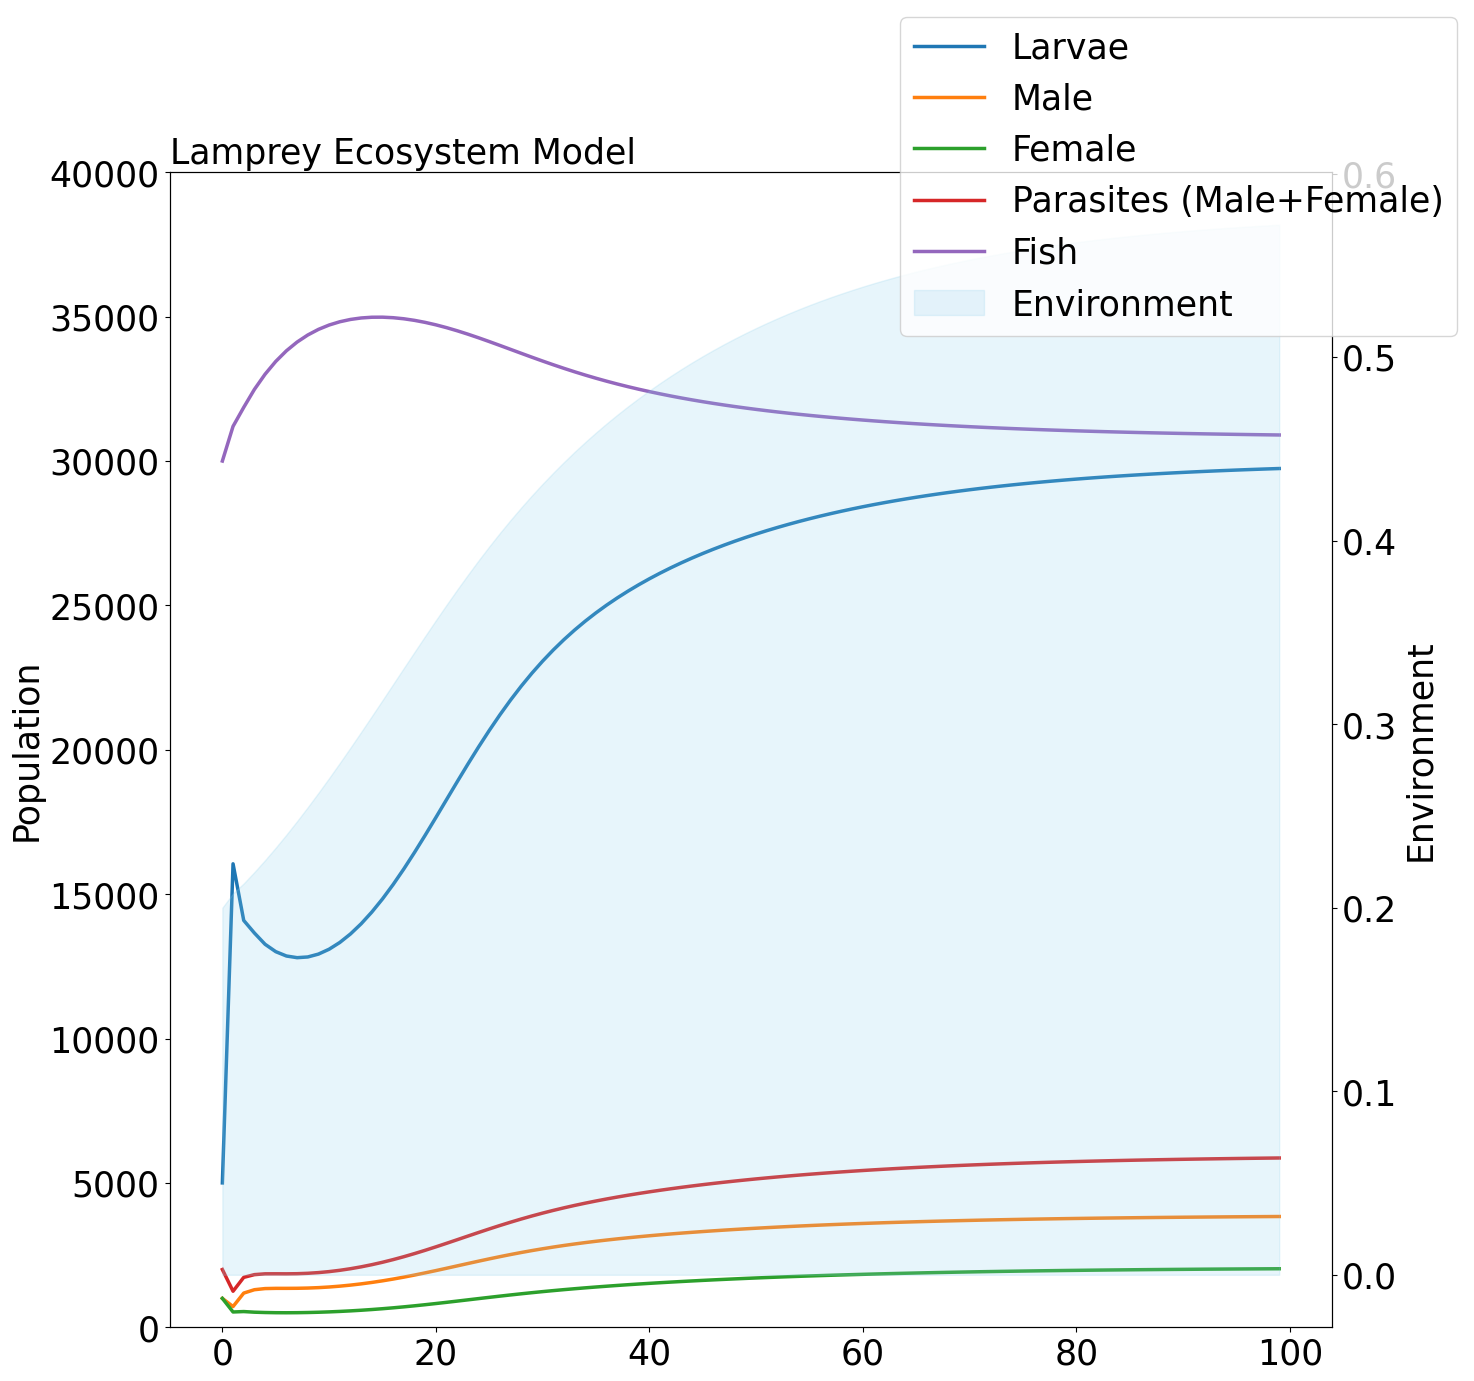

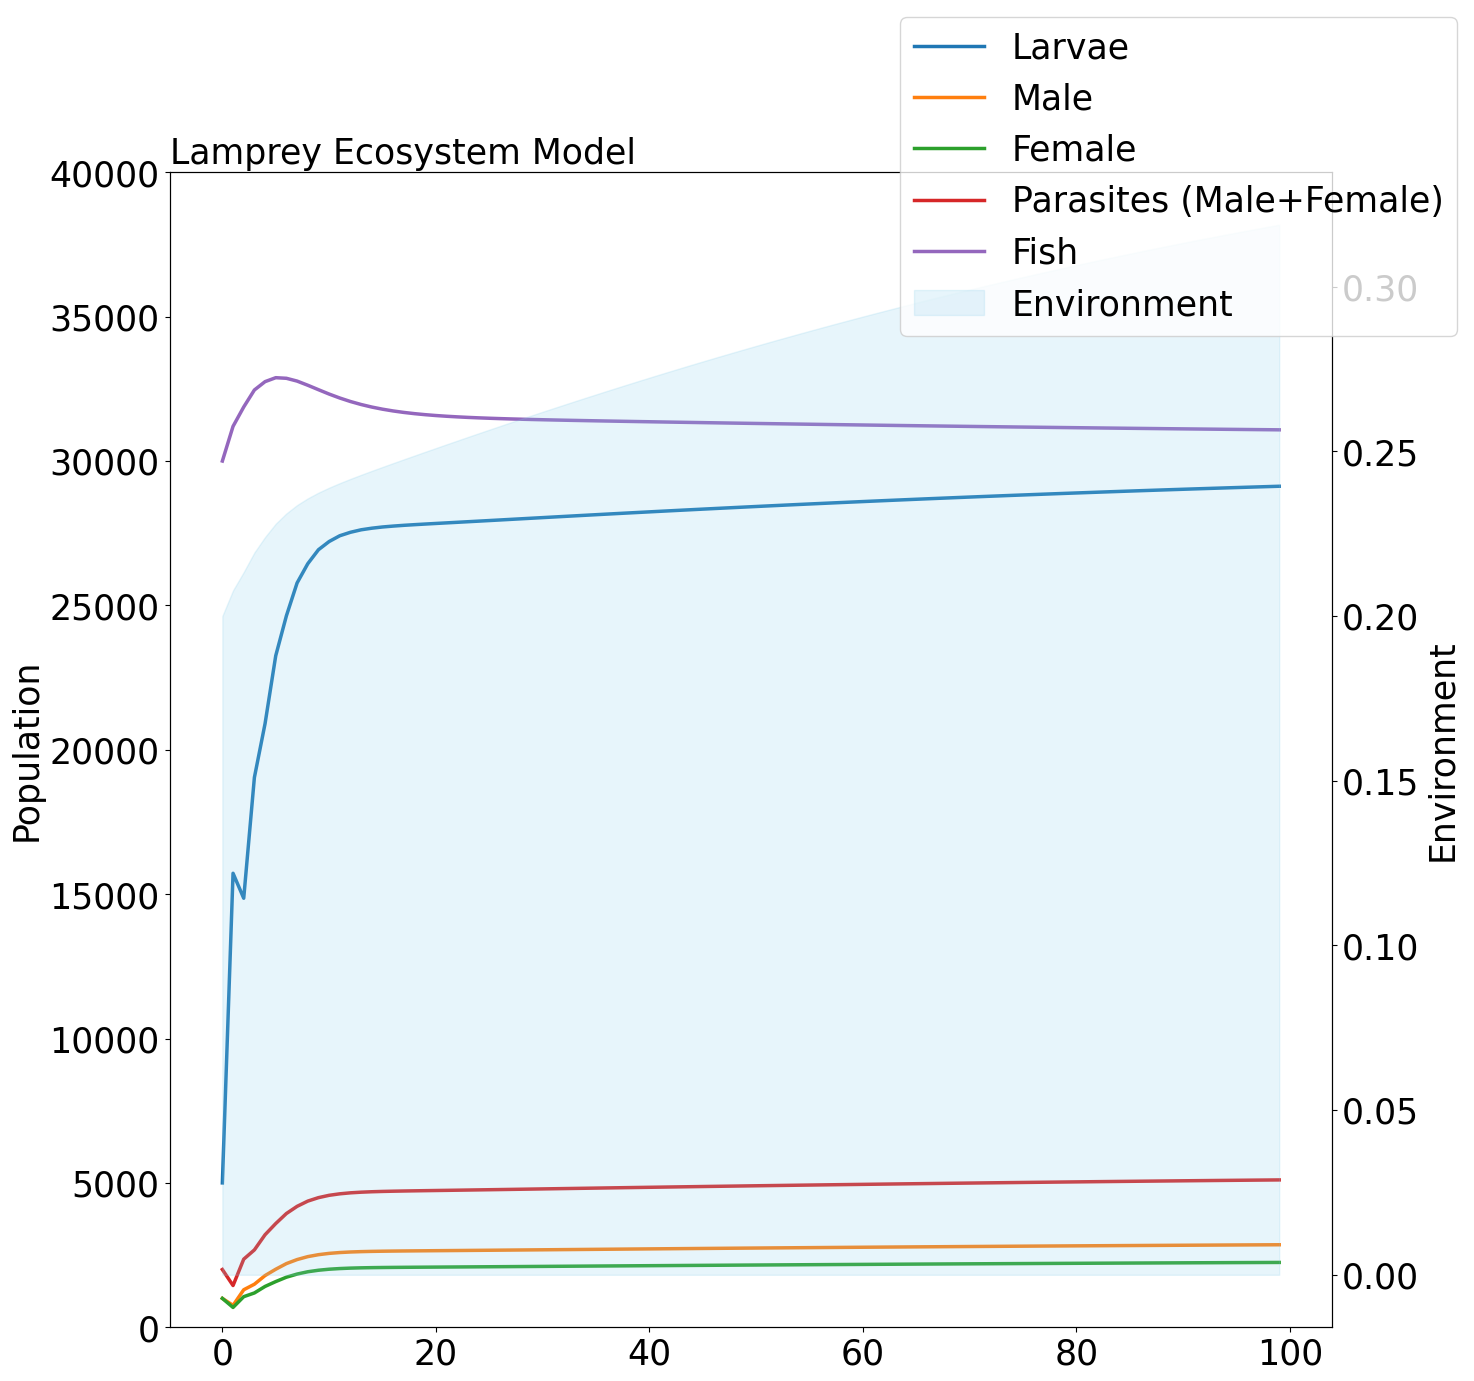

Natural larval deaths with sex ratio change: 9034.000587341096
Natural larval deaths without change: 13030.6574448103
Natural juvenile deaths with sex ratio change: 1920.7416887405213
Natural juvenile deaths without change: 2033.9848156149524


In [5]:
model_sex_change = Model(
    E_init=0.2,
    num_years=100
)
model_sex_change.graph_model()

model_no_change = Model(
    E_init=0.2,
    num_years=100,
    constant_male_ratio=0.56,
    constant_metamorphism_rate=1/4
)
model_no_change.graph_model()

avg_larval_death_change = np.mean(model_sex_change.df['larval_deaths'])
avg_larval_death_no_change = np.mean(model_no_change.df['larval_deaths'])
print(f'Natural larval deaths with sex ratio change: {avg_larval_death_change}')
print(f'Natural larval deaths without change: {avg_larval_death_no_change}')

avg_juv_death_change = np.mean(model_sex_change.df['juvenile_natural_deaths'])
avg_juv_death_no_change = np.mean(model_no_change.df['juvenile_natural_deaths'])
print(f'Natural juvenile deaths with sex ratio change: {avg_juv_death_change}')
print(f'Natural juvenile deaths without change: {avg_juv_death_no_change}')

## Phase Diagram

Build 20 different models with different initial E and with sex ratio change, and repeat this for no change

Plot the phase diagram of E_init ranging from 0 to 1.

We see that for a population that can change it's sex ratio, it converges to a higher E.

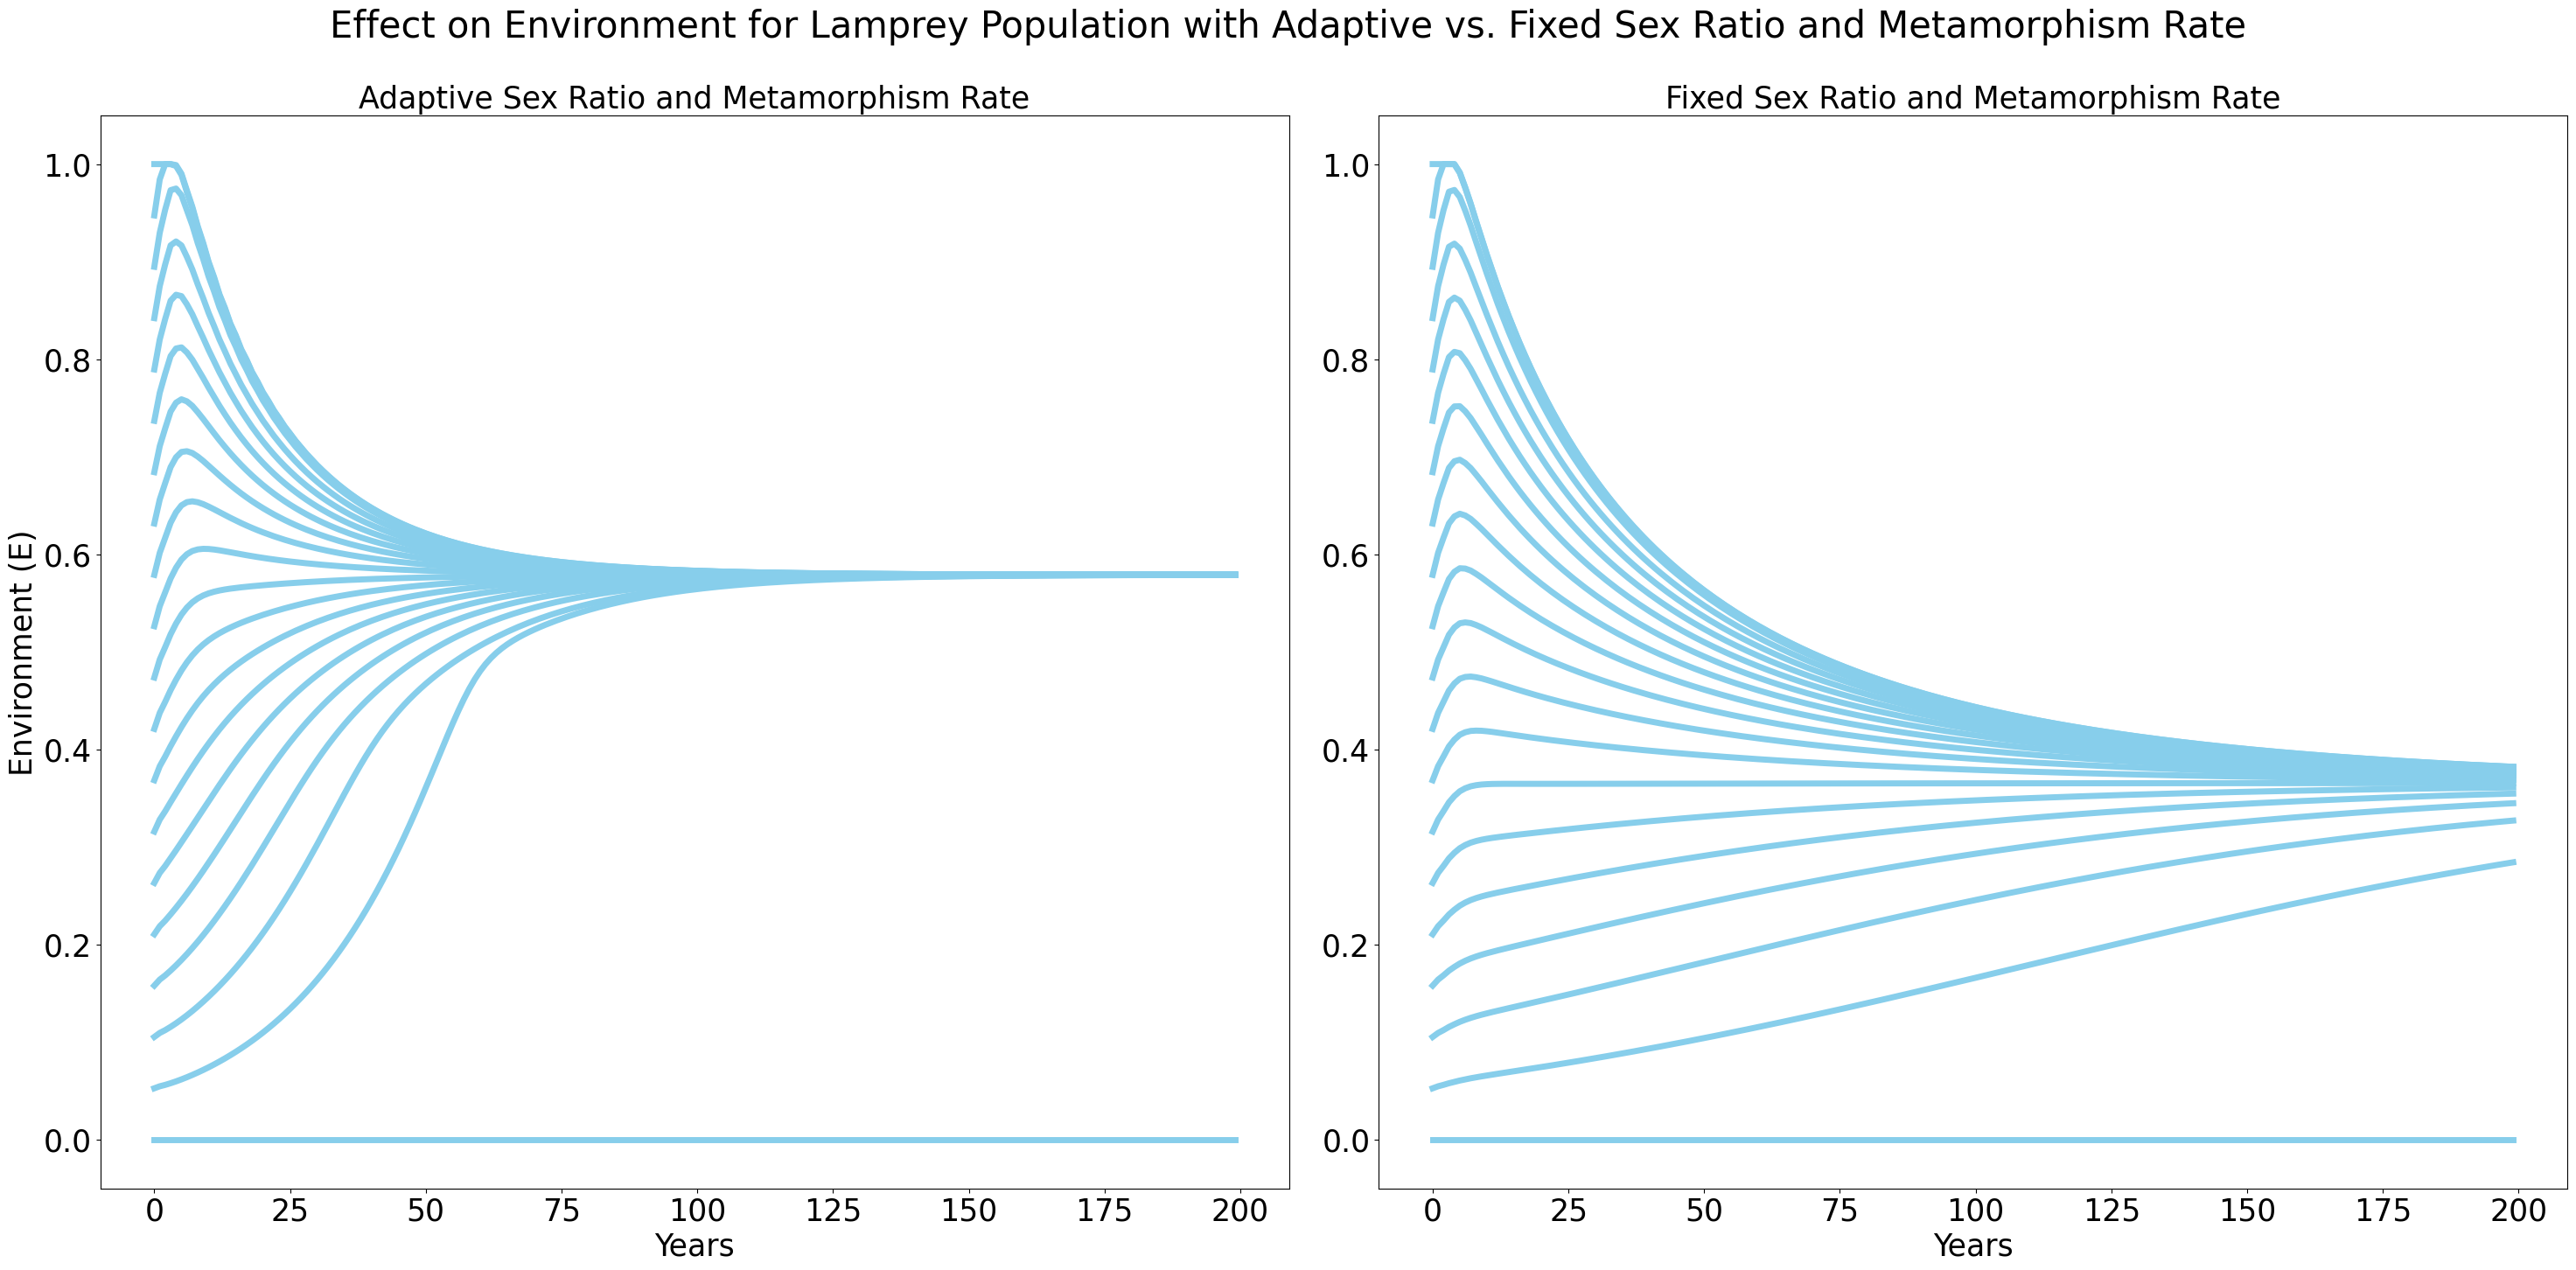

In [6]:
num = 20
years = 200
E_sex_change = np.zeros((num, years))
E_no_sex_change = np.zeros((num, years))
models_sex_change_list = []
models_no_sex_change_list = []
for i, E_init in enumerate(np.linspace(0, 1, num)):
    model_sex_change = Model(
        E_init=E_init,
        num_years=years
    )
    E_sex_change[i] = np.concatenate(([E_init], model_sex_change.df["E"].to_numpy()))
    models_sex_change_list.append(model_sex_change)

    model_no_change = Model(
        E_init=E_init,
        num_years=years,
        constant_male_ratio=0.56,
        constant_metamorphism_rate=1/4
    )
    E_no_sex_change[i] = np.concatenate(([E_init], model_no_change.df["E"].to_numpy()))
    models_no_sex_change_list.append(model_no_change)

#### Plotting
plt.rcParams.update({
    "font.size": 25,
    "axes.titlesize": 25,
    "axes.labelsize": 25,
    "xtick.labelsize": 25,
    "ytick.labelsize": 25,
    "legend.fontsize": 25,
    "lines.linewidth": 5
})

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
for i in range(num):
    axes[0].plot(np.arange(0, years), E_sex_change[i], color='skyblue')
axes[0].set_title("Adaptive Sex Ratio and Metamorphism Rate")
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Environment (E)")

for i in range(num):
    axes[1].plot(np.arange(0, years), E_no_sex_change[i], color='skyblue')
axes[1].set_title("Fixed Sex Ratio and Metamorphism Rate")
axes[1].set_xlabel("Years")

fig.suptitle("Effect on Environment for Lamprey Population with Adaptive vs. Fixed Sex Ratio and Metamorphism Rate")
plt.tight_layout()
plt.show()

plt.rcParams.update(plt.rcParamsDefault)

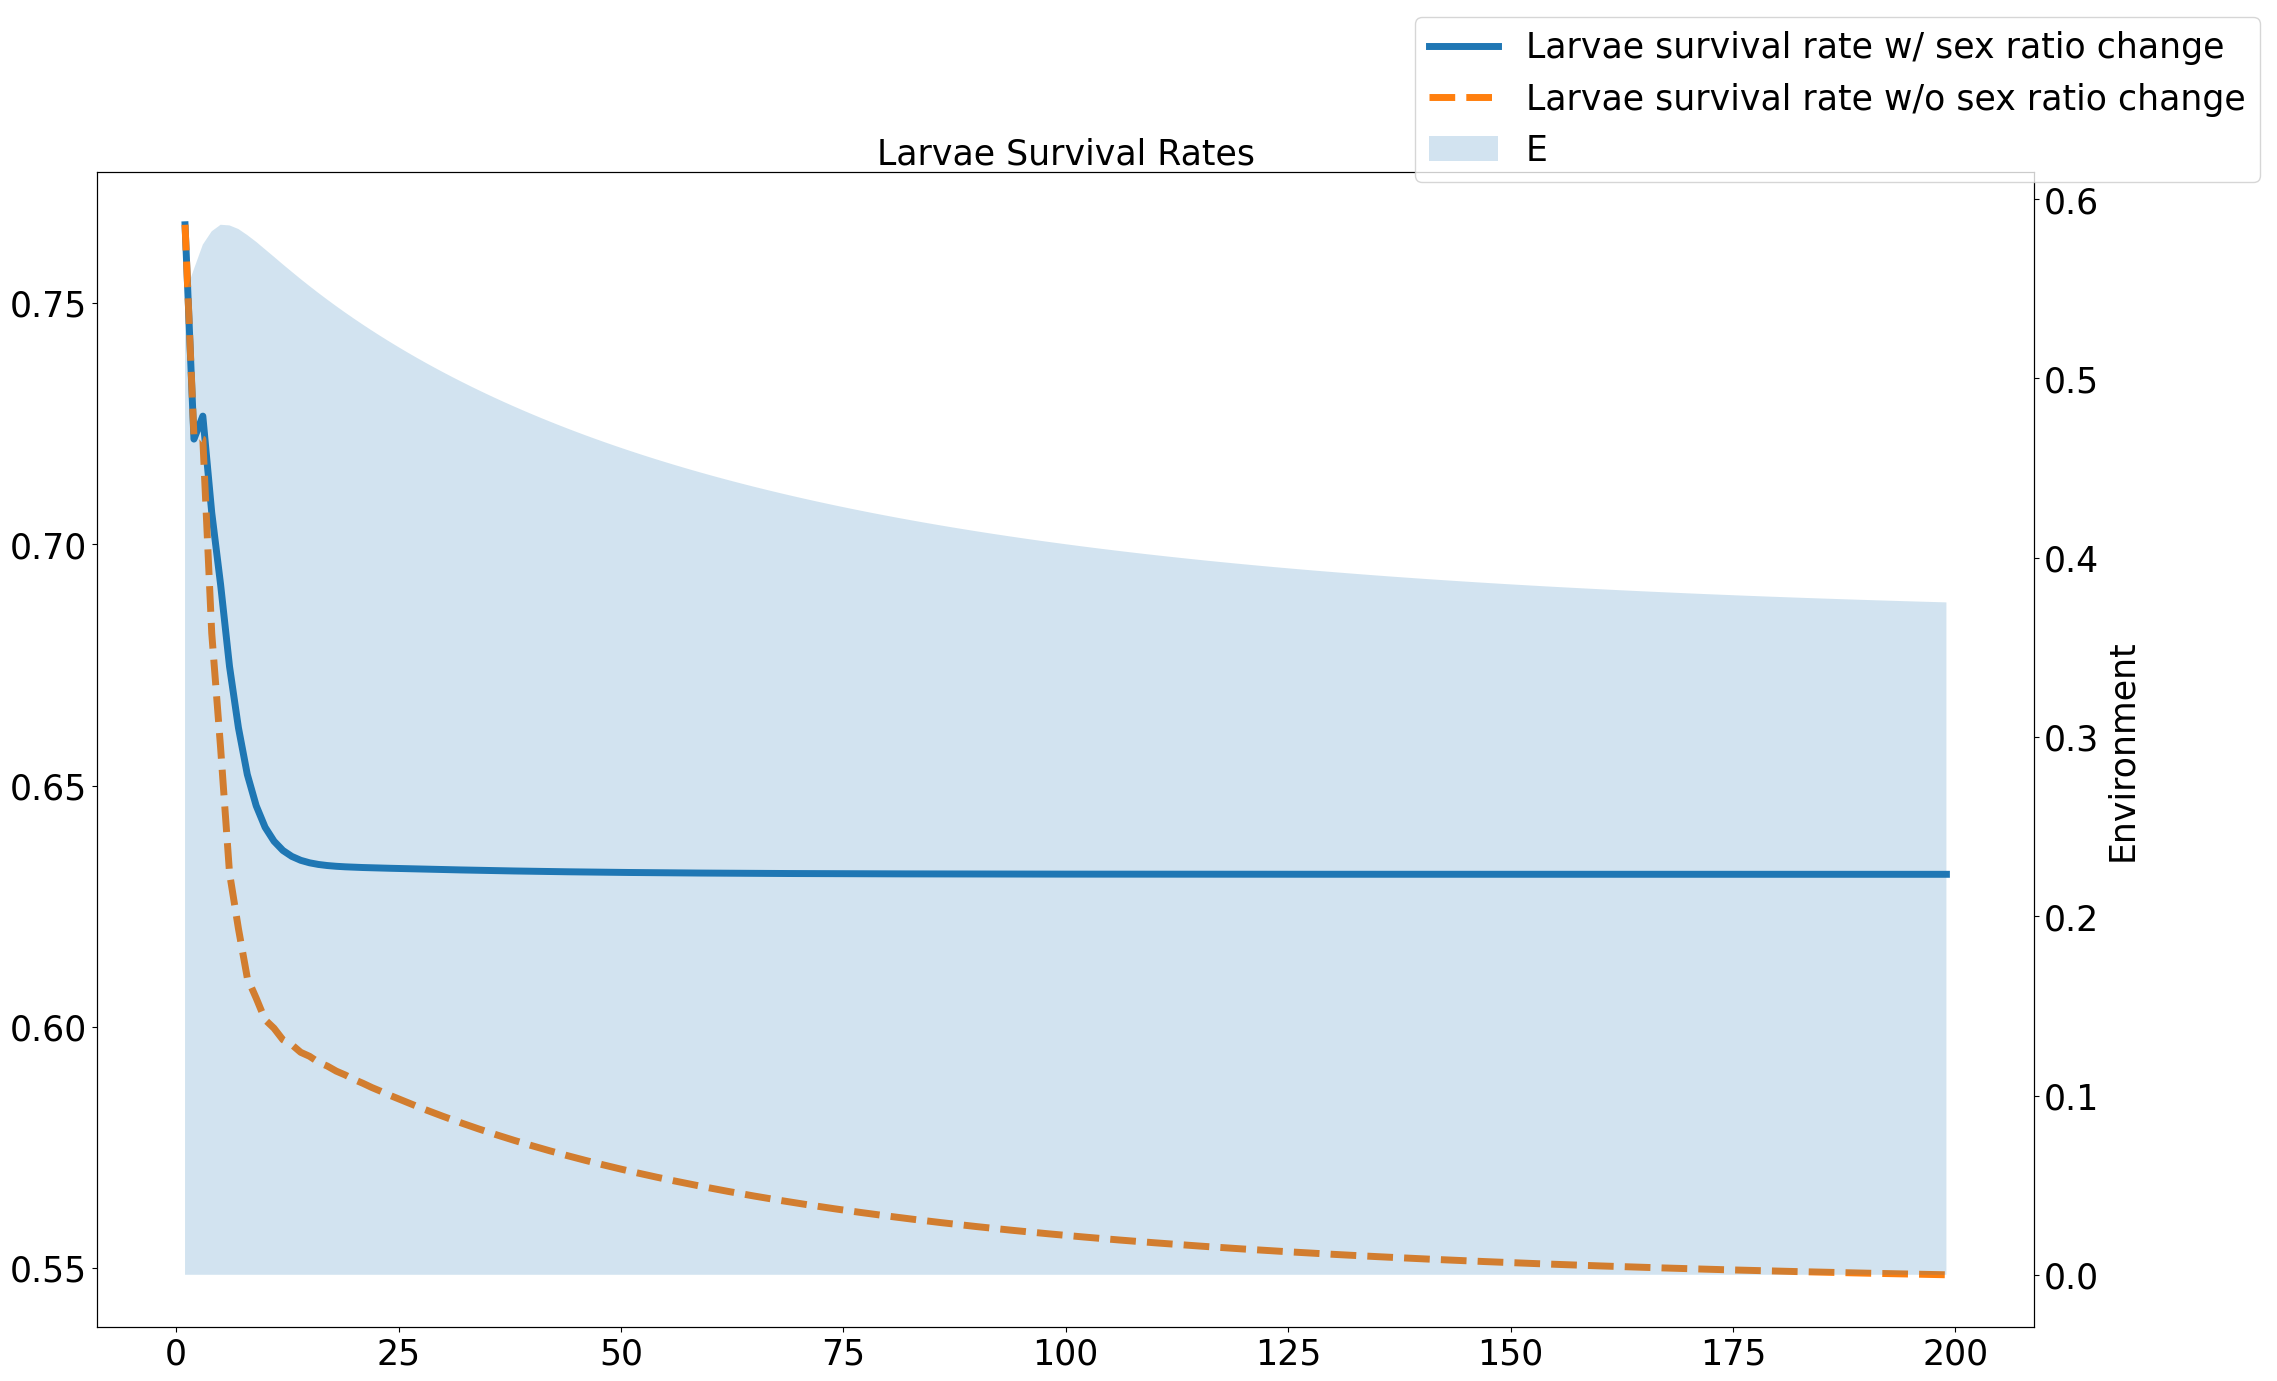

In [7]:
model_sex_change = models_sex_change_list[10]
model_no_change = models_no_sex_change_list[10]

plt.rcParams.update({
            "font.size": 25,
            "axes.titlesize": 25,
            "axes.labelsize": 25,
            "xtick.labelsize": 25,
            "ytick.labelsize": 25,
            "legend.fontsize": 25,
            "lines.linewidth": 5
})

fig, ax1 = plt.subplots(figsize=(25,15))
ax2 = ax1.twinx()  # Create a second x-axis sharing the same y-axis

ax1.plot(model_sex_change.df["year"], model_sex_change.df["larval_survival_rate"], label="Larvae survival rate w/ sex ratio change")
ax1.plot(model_no_change.df["year"], model_no_change.df["larval_survival_rate"], '--', label="Larvae survival rate w/o sex ratio change")

ax2.fill_between(model_sex_change.df["year"], model_no_change.df["E"], alpha=0.2, label="E")
ax2.set_ylabel("Environment")

fig.legend()
plt.title("Larvae Survival Rates")
plt.show()

plt.rcParams.update(plt.rcParamsDefault)

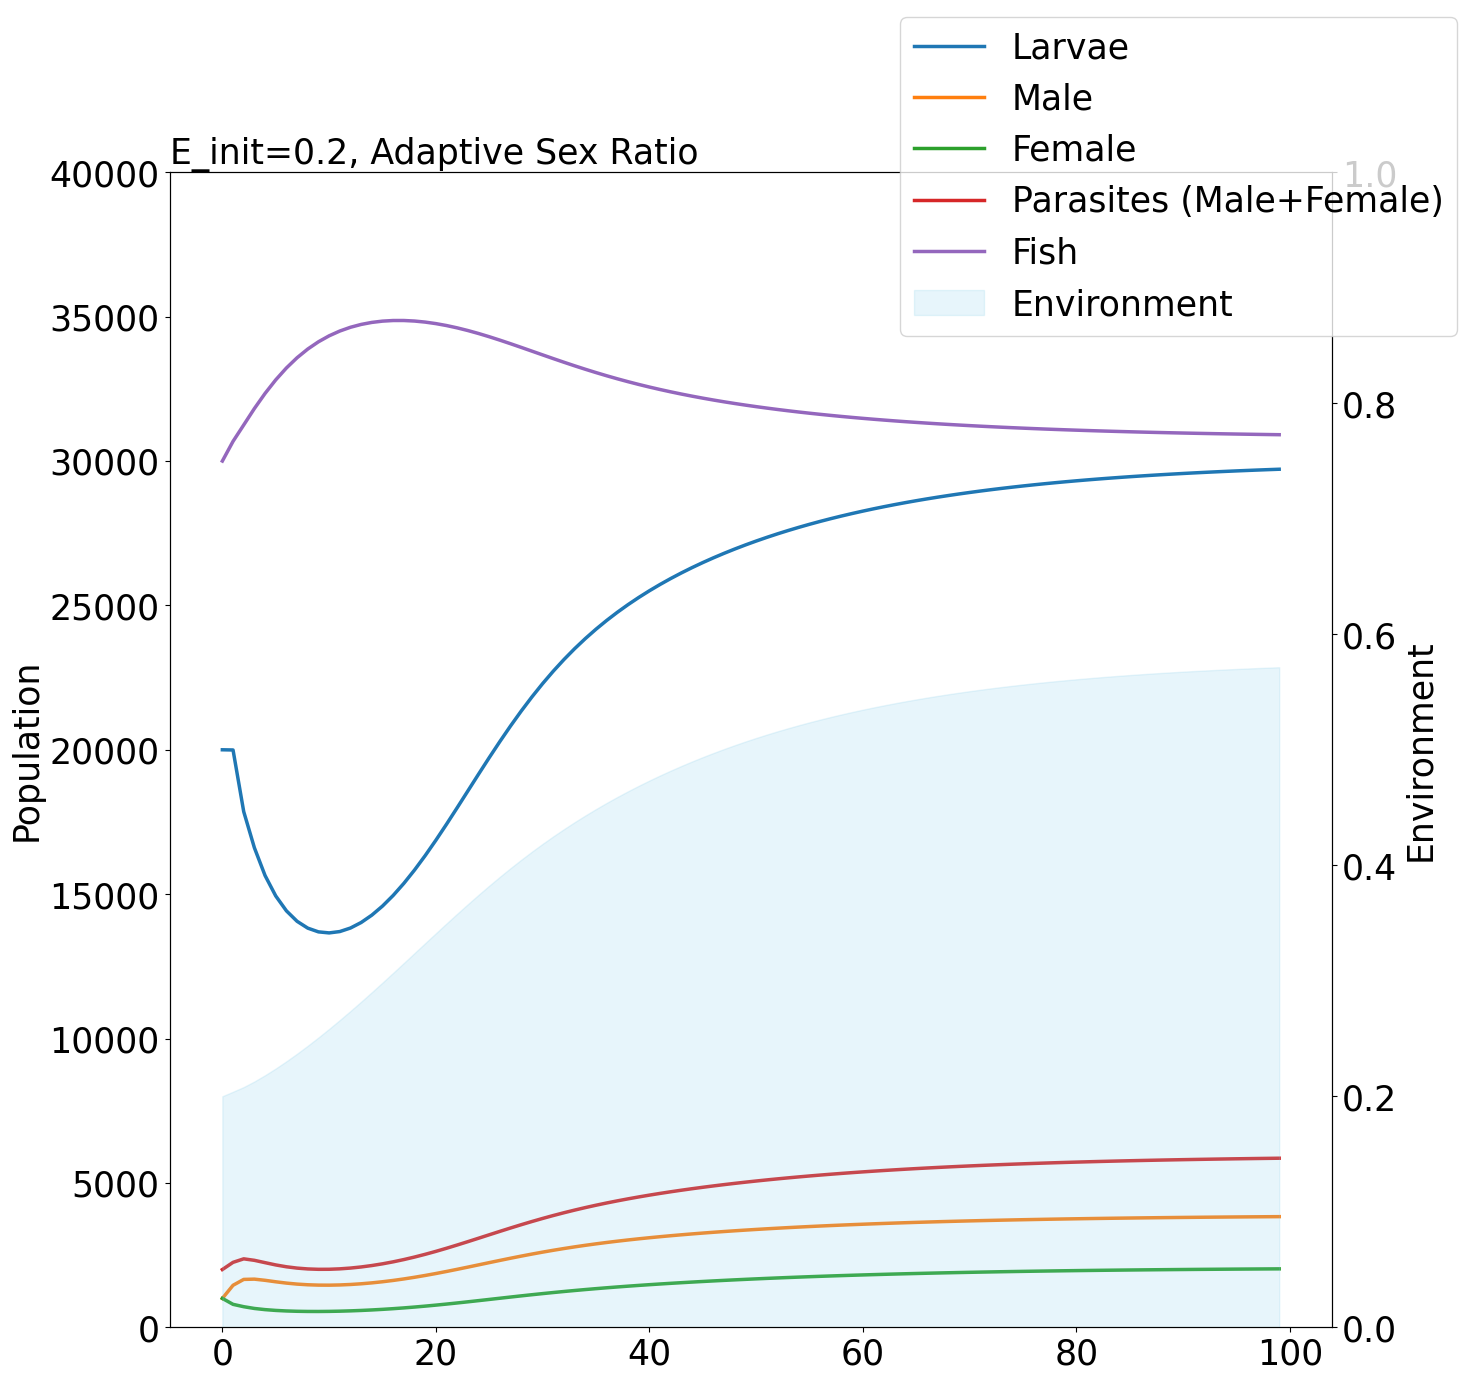

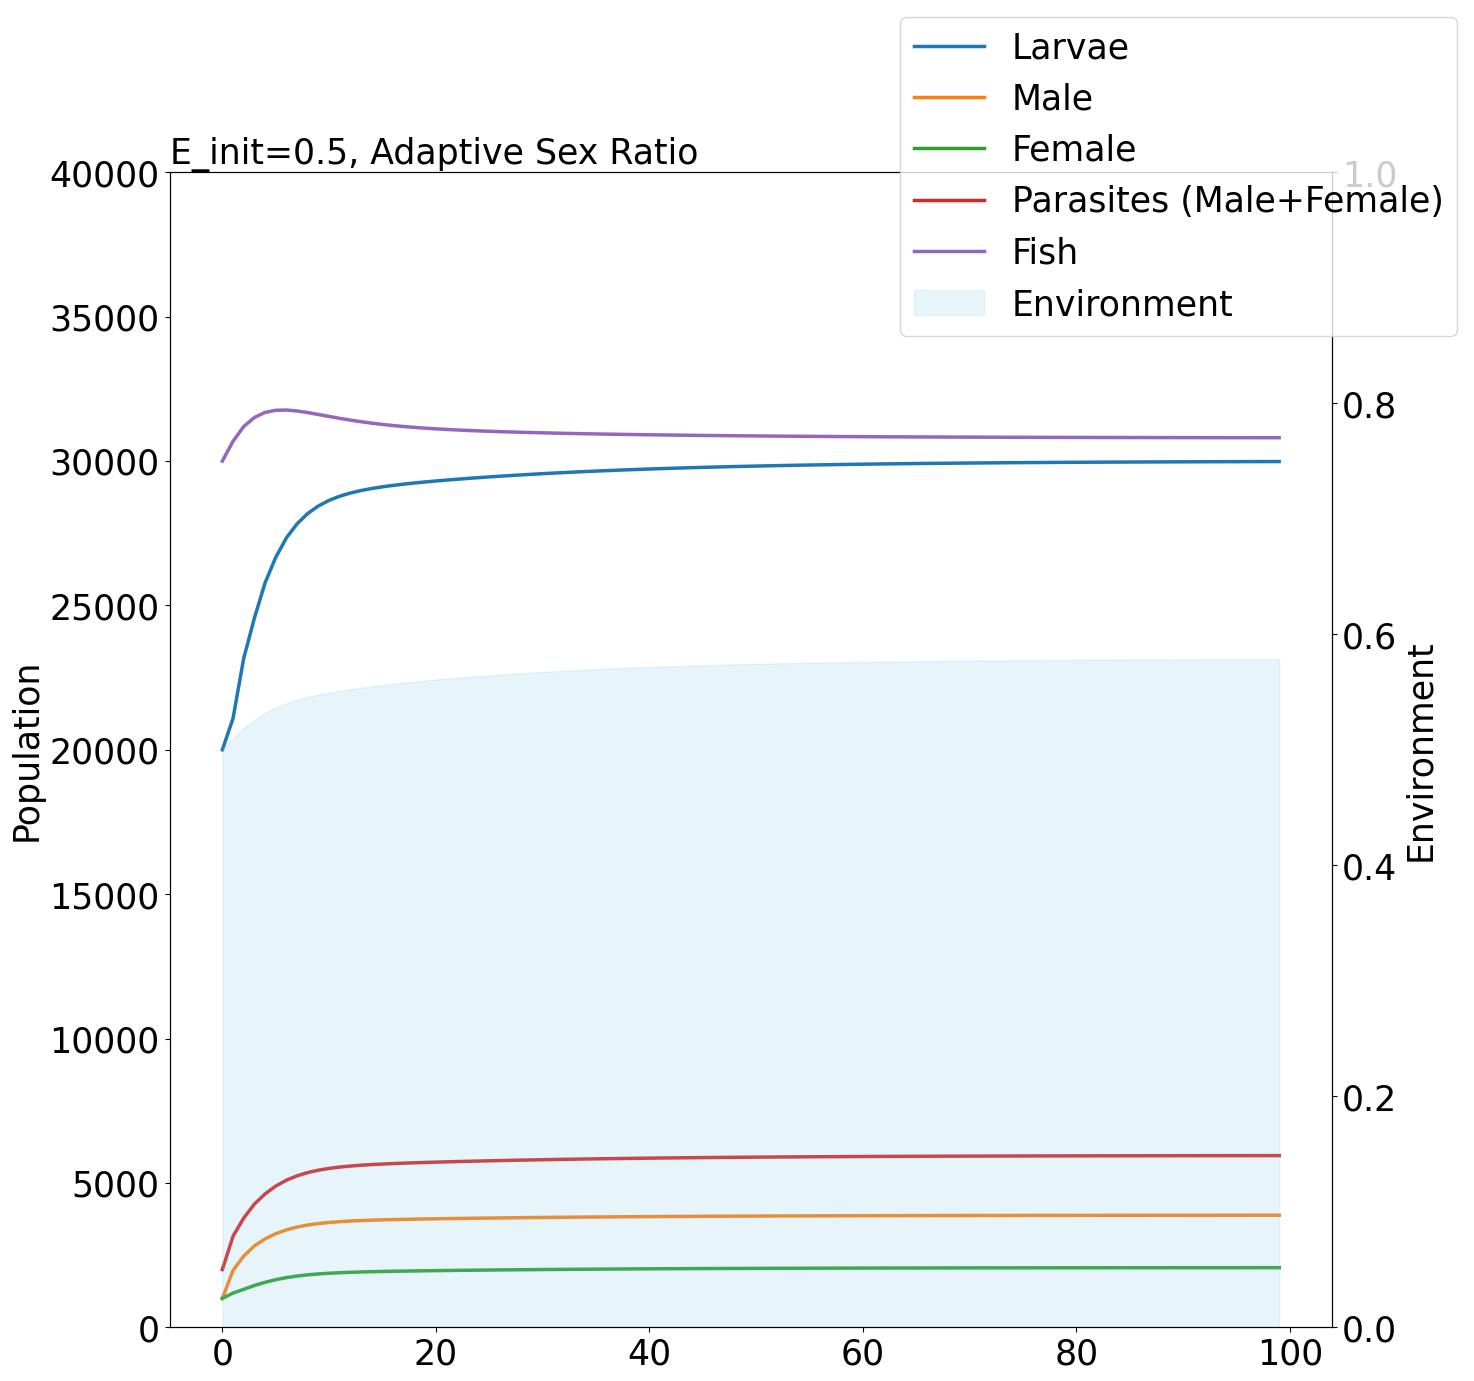

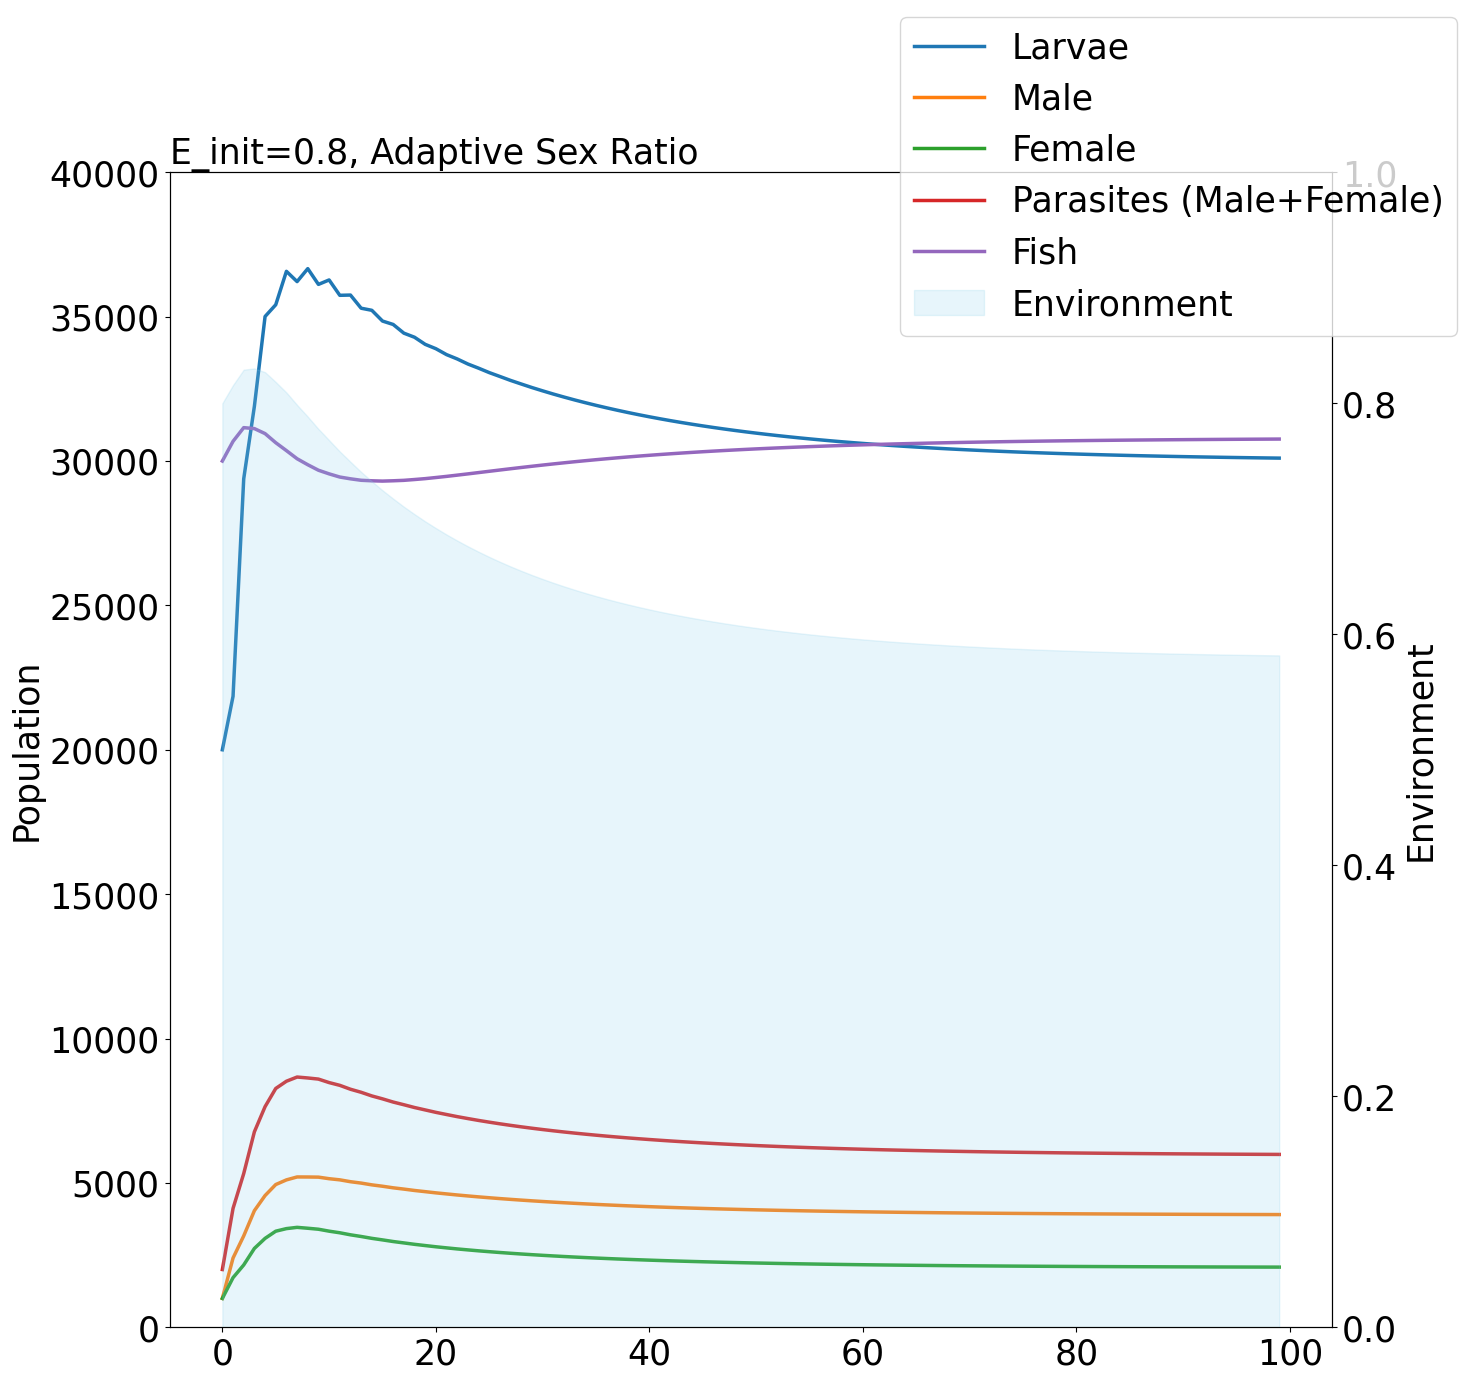

In [10]:
model_no_change = Model(
    E_init=0.2,
    num_years=100,
    Larva_init=20000
)
model_no_change.graph_model(title="E_init=0.2, Adaptive Sex Ratio", Y_lim=True, E_lim=True)

model_no_change = Model(
    E_init=0.5,
    num_years=100,
    Larva_init=20000
)
model_no_change.graph_model(title="E_init=0.5, Adaptive Sex Ratio", Y_lim=True, E_lim=True)

model_no_change = Model(
    E_init=0.8,
    num_years=100,
    Larva_init=20000
)
model_no_change.graph_model(title="E_init=0.8, Adaptive Sex Ratio", Y_lim=True, E_lim=True)

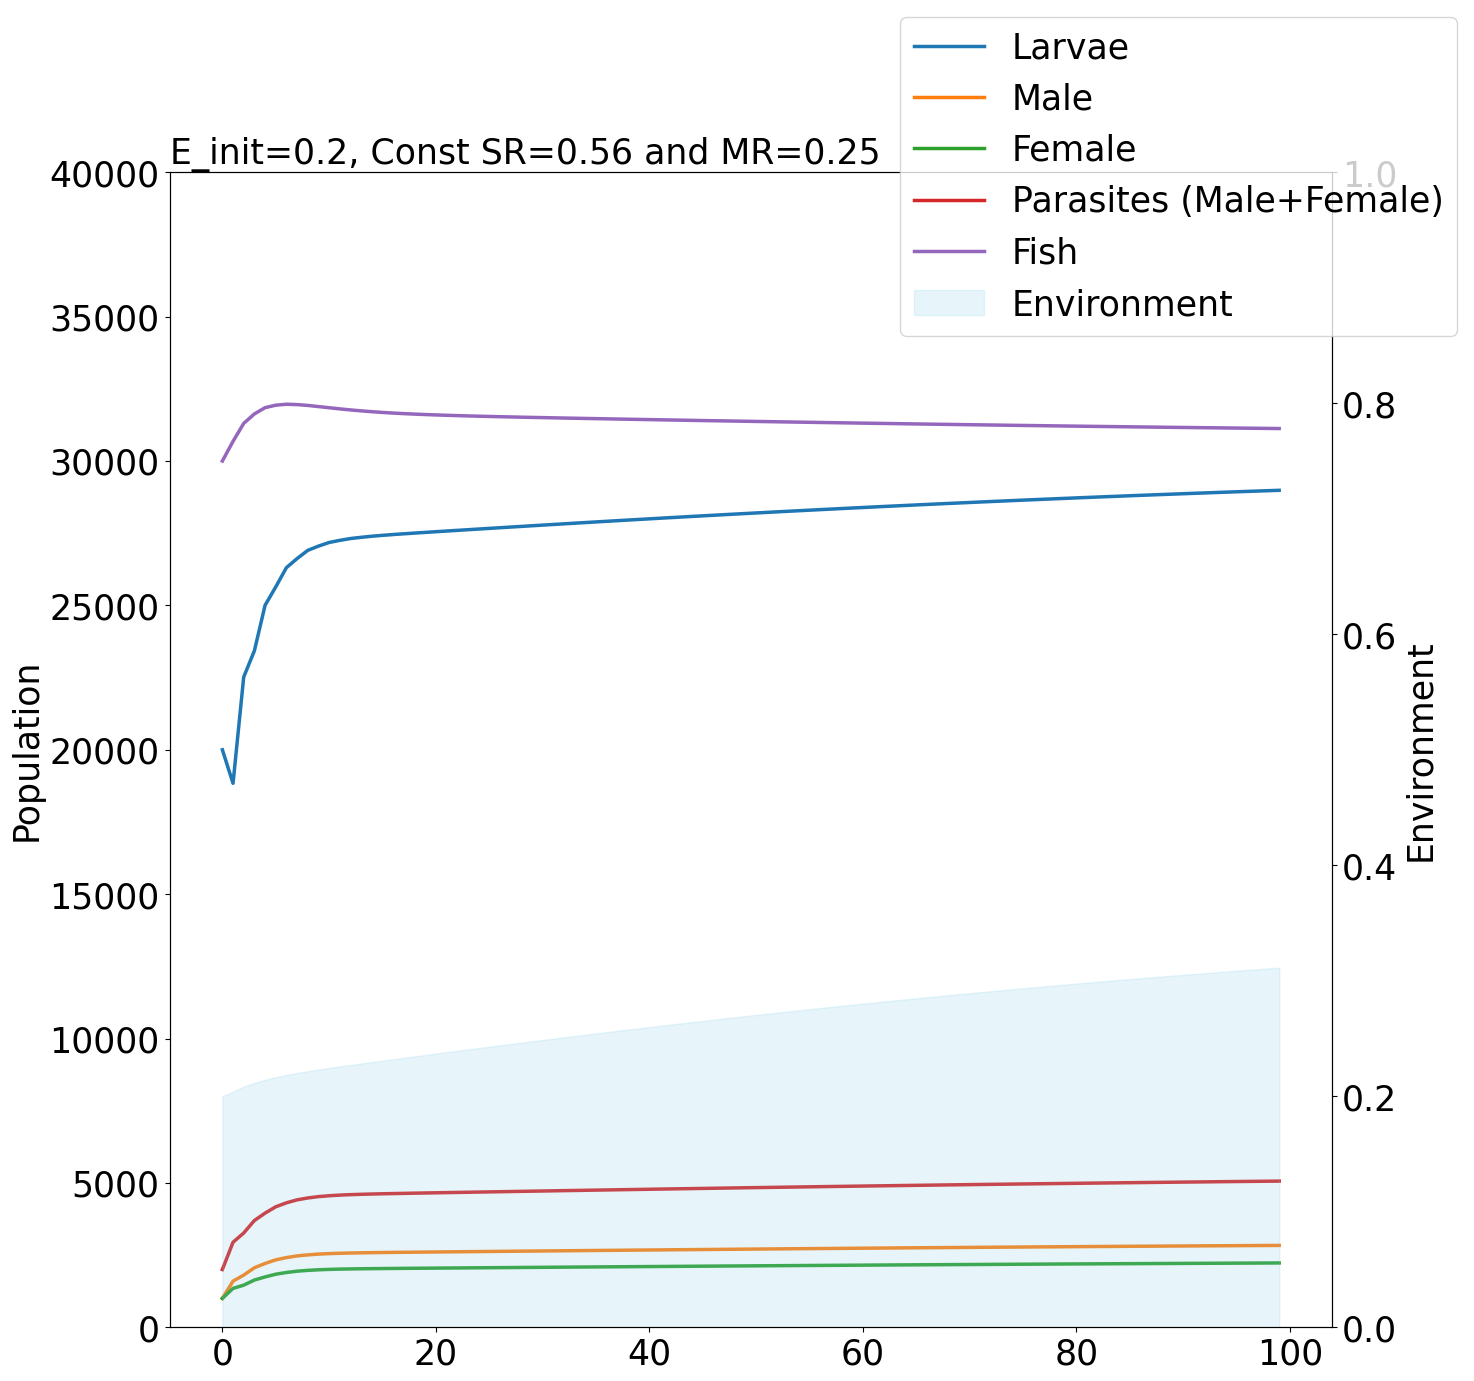

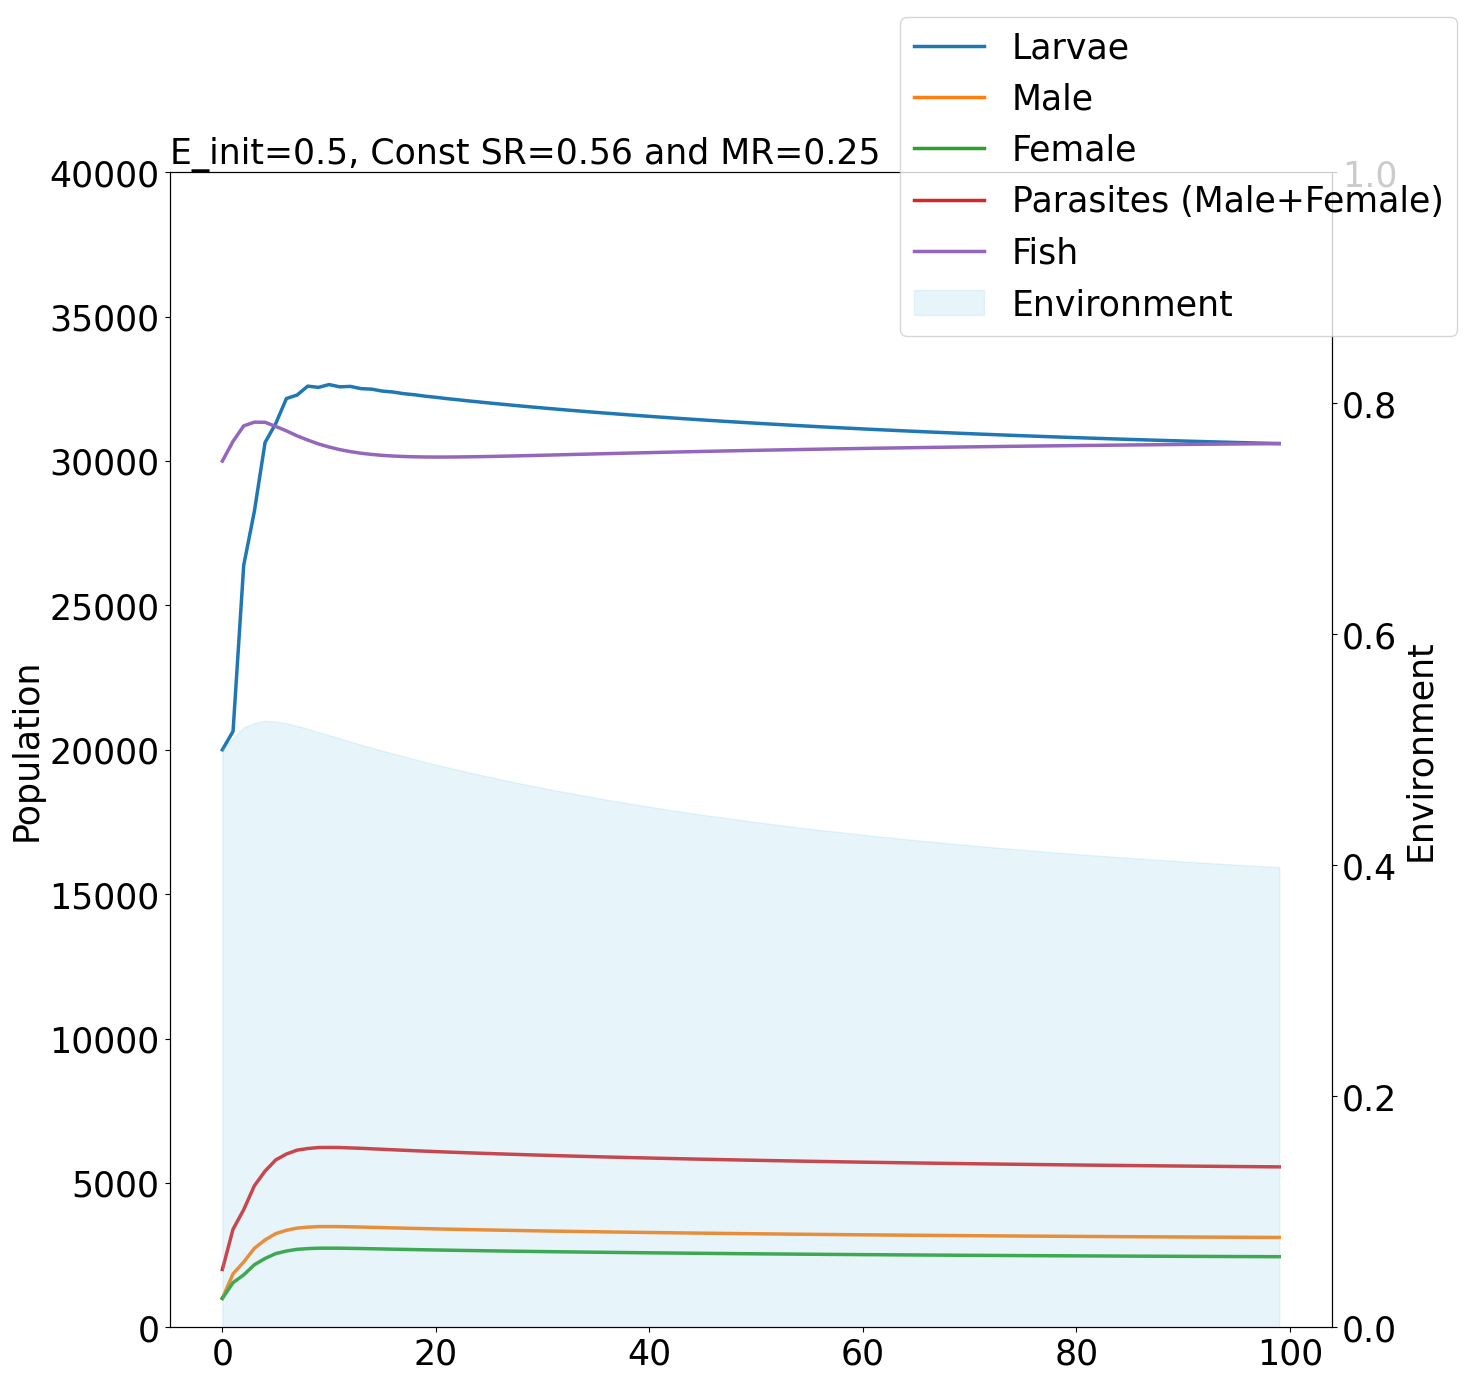

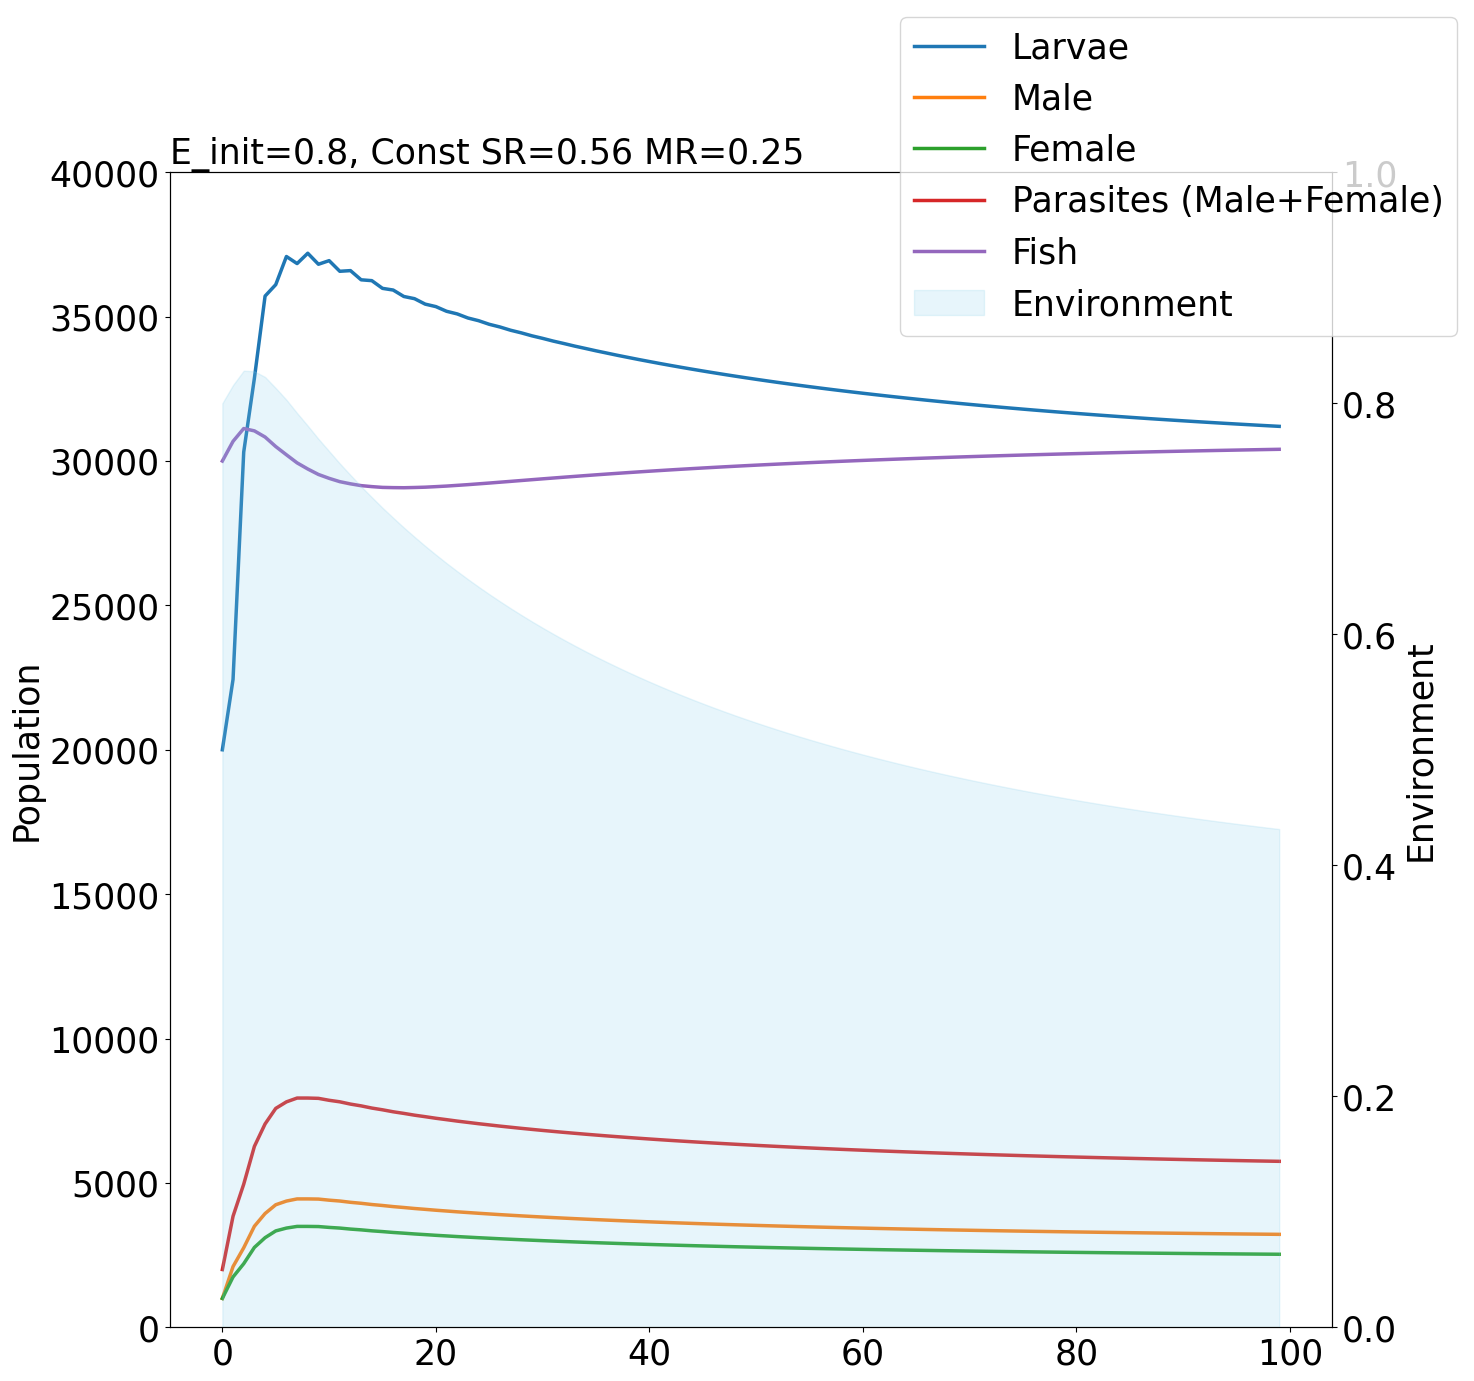

In [11]:
model_no_change = Model(
    E_init=0.2,
    num_years=100,
    Larva_init=20000,
    constant_male_ratio=0.56,
    constant_metamorphism_rate=1/4
)
model_no_change.graph_model(title="E_init=0.2, Const SR=0.56 and MR=0.25", Y_lim=True, E_lim=True)

model_no_change = Model(
    E_init=0.5,
    num_years=100,
    Larva_init=20000,
    constant_male_ratio=0.56,
    constant_metamorphism_rate=1/4
)
model_no_change.graph_model(title="E_init=0.5, Const SR=0.56 and MR=0.25", Y_lim=True, E_lim=True)

model_no_change = Model(
    E_init=0.8,
    num_years=100,
    Larva_init=20000,
    constant_male_ratio=0.56,
    constant_metamorphism_rate=1/4
)
model_no_change.graph_model(title="E_init=0.8, Const SR=0.56 MR=0.25", Y_lim=True, E_lim=True)